# CREATE PATHWAYS

In [30]:
import sys
import json
default = {'scenario': 'base', 'training_folder': '../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.model import stepmodel
from quetzal.io import excel

if manual:
    %matplotlib inline

var = excel.read_var(file = '../../inputs/parameters.xlsx', scenario = argv['scenario'])

## Read model

In [31]:
sm = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/road_model'.format(scen=argv['scenario']))

lines: 100%|██████████| 22/22 [00:00<00:00, 32.40it/s]     


# Clusterize Transport Nodes 

In [32]:
sm.preparation_clusterize_nodes(300)
sm.nodes.index = 'node_' + sm.nodes.index.astype(str)
sm.links.a = 'node_' + sm.links.a.astype(str)
sm.links.b = 'node_' + sm.links.b.astype(str)

KeyboardInterrupt: 

# Footpaths
Footpaths are pathways connecting public transport nodes. Attribute *sm.footpaths* will be added.

In [ ]:
kwargs_footpaths = var["preparation_footpaths"].to_dict()
kwargs_footpaths

{'max_length': 3000.0, 'speed': 3.0, 'n_clusters': 3000}

In [ ]:
sm.preparation_footpaths(**kwargs_footpaths)
sm.footpaths.head(1)

a    b                                           geometry  \
footpath_0  153  194  LINESTRING (259030.9929192302 6258081.86189241...   

                 length  voronoi         time  
footpath_0  1936.609746        1  2323.931695

# Access and Eggress
Acces and Eggress (also called ntlegs) are pathways connecting zones to transport nodes and road node (if walk on road is activated). Those attributes are added:
- *sm.zone_to_transit* (if zone_to_transit=True)
- *sm.zone_to_road* (if zone_to_road=True)
- *sm.road_to_transit* (if zone_to_road=True)

In [ ]:
kwargs_ntlegs = var["preparation_ntlegs"].to_dict()
kwargs_ntlegs

{'n_ntlegs': 5,
 'max_ntleg_length': 5000.0,
 'long_leg_speed': 7.0,
 'short_leg_speed': 3.0,
 'threshold': 500.0}

In [ ]:
sm.preparation_ntlegs(zone_to_transit=True,
                        zone_to_road=True,
                        **kwargs_ntlegs)

sm._add_type_prefixes(prefixes={'zone_to_transit': 'ztt_', 
                                'zone_to_road': 'ztr_', 
                                'road_to_transit': 'rtt_'})
sm.zone_to_transit.head(1)

a    b  rank    distance  \
ztt_0  zone_0  210     0  374.599337   

                                                geometry direction  \
ztt_0  LINESTRING (259852.4406498849 6251299.59777299...    access   

       speed_factor  short_leg_speed  long_leg_speed  speed        time  \
ztt_0      0.865563              3.0             7.0    3.0  449.519204   

        walk_time  
ztt_0  449.519204

# Export

In [ ]:
sm.to_zippedpickles(argv['training_folder'] + '/model/{scen}/walk_model'.format(scen=argv['scenario']))  

zone_to_road: 100%|██████████| 29/29 [00:01<00:00, 17.46it/s]             


# PLOT 
## Clustering

In [ ]:
if not manual:
    end_of_notebook
    
import matplotlib.pyplot as plt

In [ ]:
def plot_clustering(self, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax_array = plt.subplots(2, 2,  figsize=figsize, tight_layout=True) 
    plot = sm.plot(
        'disaggregated_nodes', markersize=10, color='green',
        basemap_url=url, title="Original Stops", fontsize=36, ax=ax_array[0][0],
    )
    plot = sm.plot(
        'node_parenthood', linewidth=1,
        ax=sm.plot('disaggregated_nodes',  markersize=10, color='green', ax=ax_array[0][1]),
        basemap_url=url, title="Stop Clusters", fontsize=36
    )
    plot = sm.plot(
        'nodes', color='green', markersize=10,
        ax=sm.plot('node_clusters', alpha=0.25, edgecolor='black', ax=ax_array[1][0]),
        basemap_url=url, title="Stop Clusters", fontsize=36
    )
    plot = sm.plot(
        'nodes', color='green', markersize=50, basemap_url=url,
        title="Aggregated stops", fontsize=36, ax=ax_array[1][1]
    )
    return fig

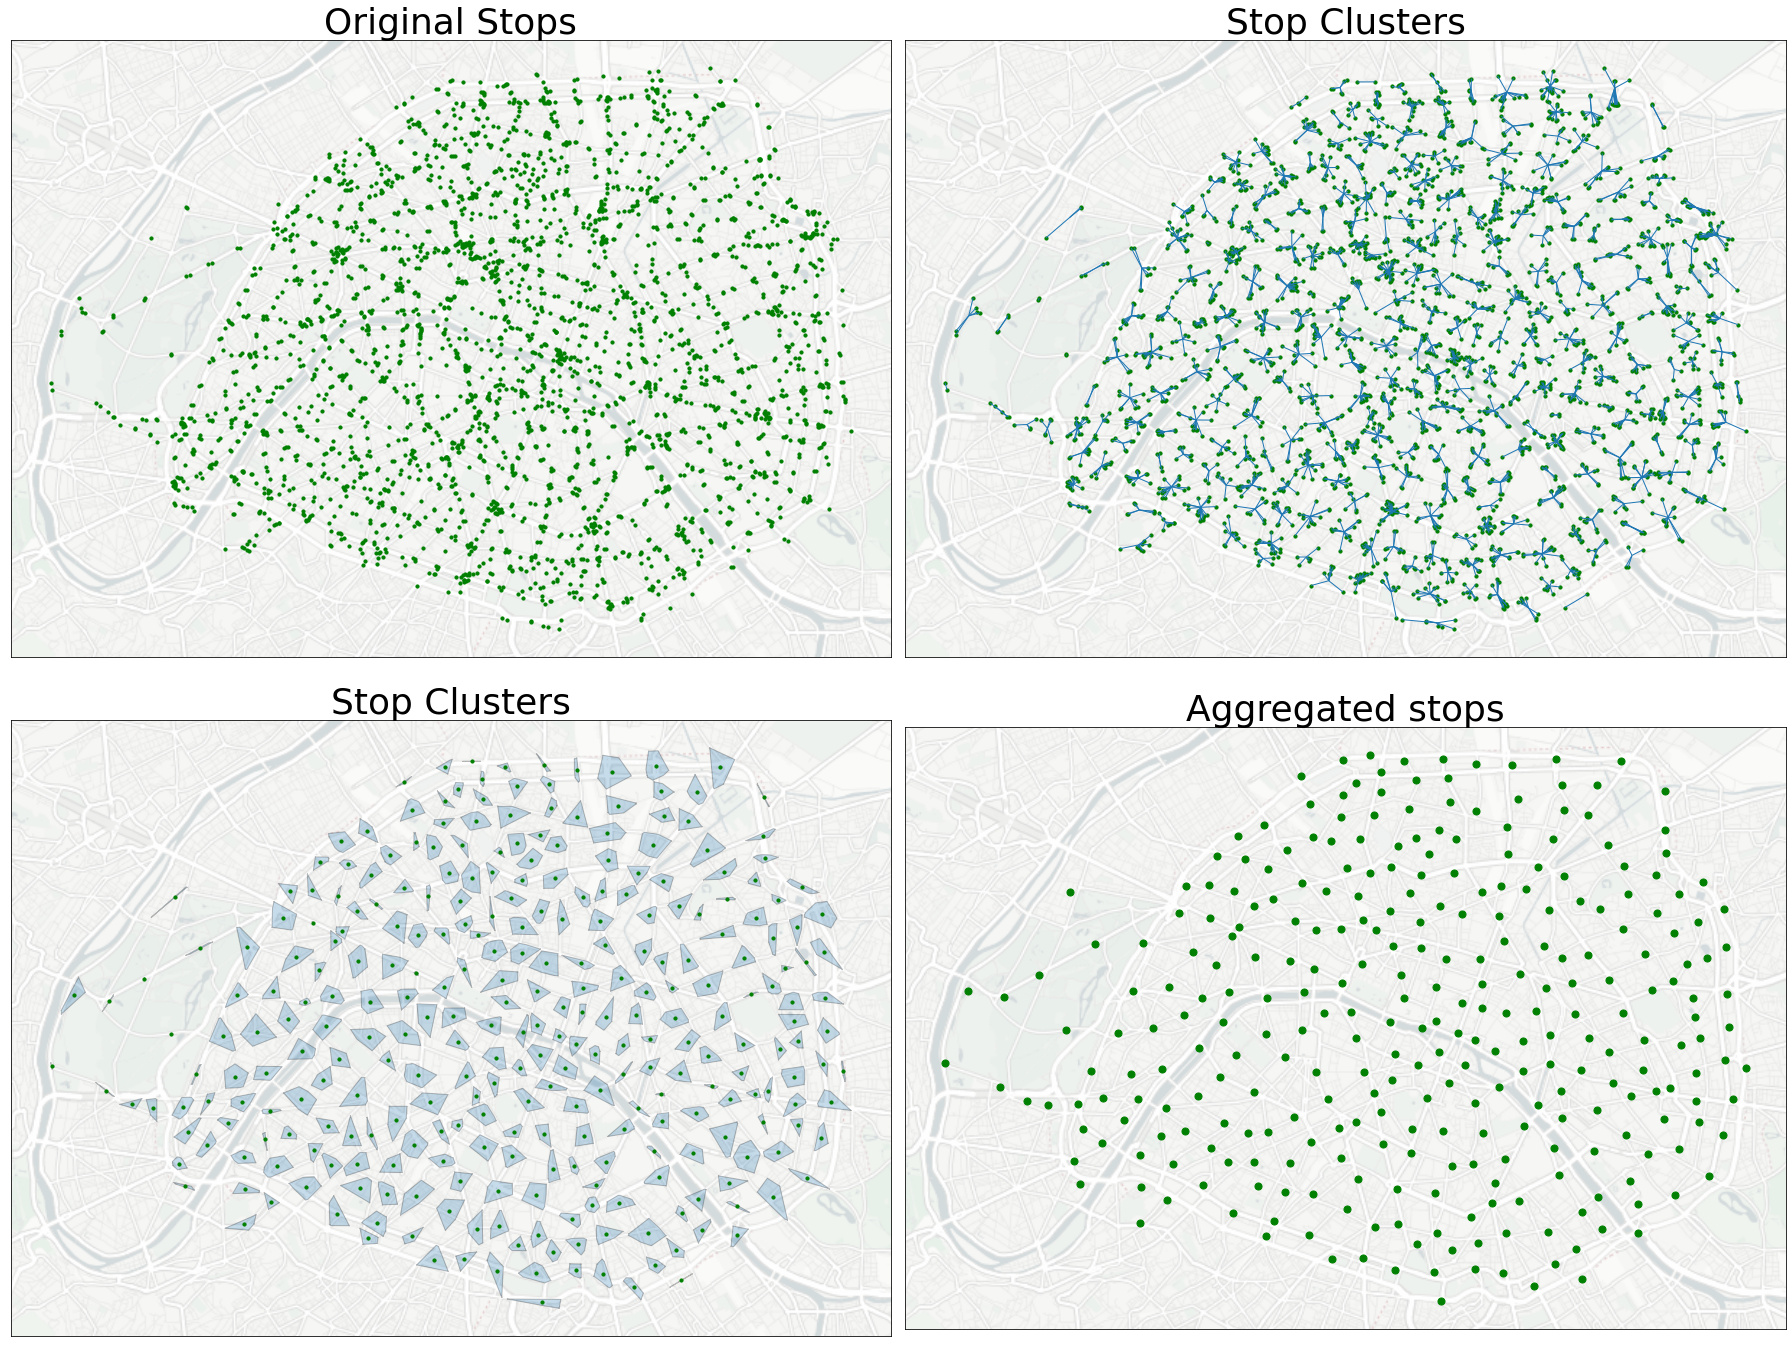

In [ ]:
if manual:
    fig = plot_clustering(sm, url='http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png')

## Walk Model

In [ ]:
def plot_walkmodel(self, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax_array = plt.subplots(2, 2,  figsize=figsize, tight_layout=True)
    plot = sm.plot('centroids', color='red', markersize=100,
        ax=sm.plot('nodes', markersize=10, color='red',
            ax=sm.plot('zone_to_transit', linewidth=1,
                      ax=sm.plot('zones', linewidth=1, alpha=1, edgecolor='black', color='none', 
                                ax=sm.plot('footpaths', alpha=0, ax=ax_array[0][0])))
        ),
        basemap_url=url,
        title="Acces and Egress links (Zone to Transit)", fontsize=36
    )
    plot = sm.plot(
        'footpaths', color=None, linewidth=1,
        ax=sm.plot('nodes', markersize=100, ax=sm.plot('zones',alpha=0, ax=ax_array[0][1])),
        basemap_url=url, title="Stops & Footpaths", fontsize=36
    )

    plot = sm.plot(
        'footpaths', color=None, linewidth=1,
        ax=sm.plot('zone_to_transit', linewidth=1,  ax=sm.plot('zones',alpha=0, ax=ax_array[1][0]) ),
        basemap_url=url,
        title="Full Pedestrian Graph (as the Crow Flies)", fontsize=36
    )
    plot = sm.plot('road_links', color='green',linewidth=0.5, ax=sm.plot(
        'road_to_transit',  linewidth=1, color='green',
        ax=sm.plot('zone_to_road', linewidth=1, color='green', ax=sm.plot('zones',alpha=0, ax=ax_array[1][1]) )),
        basemap_url=url,
        title="Full Pedestrian Graph (Walk on Road)", fontsize=36
    )
    return fig

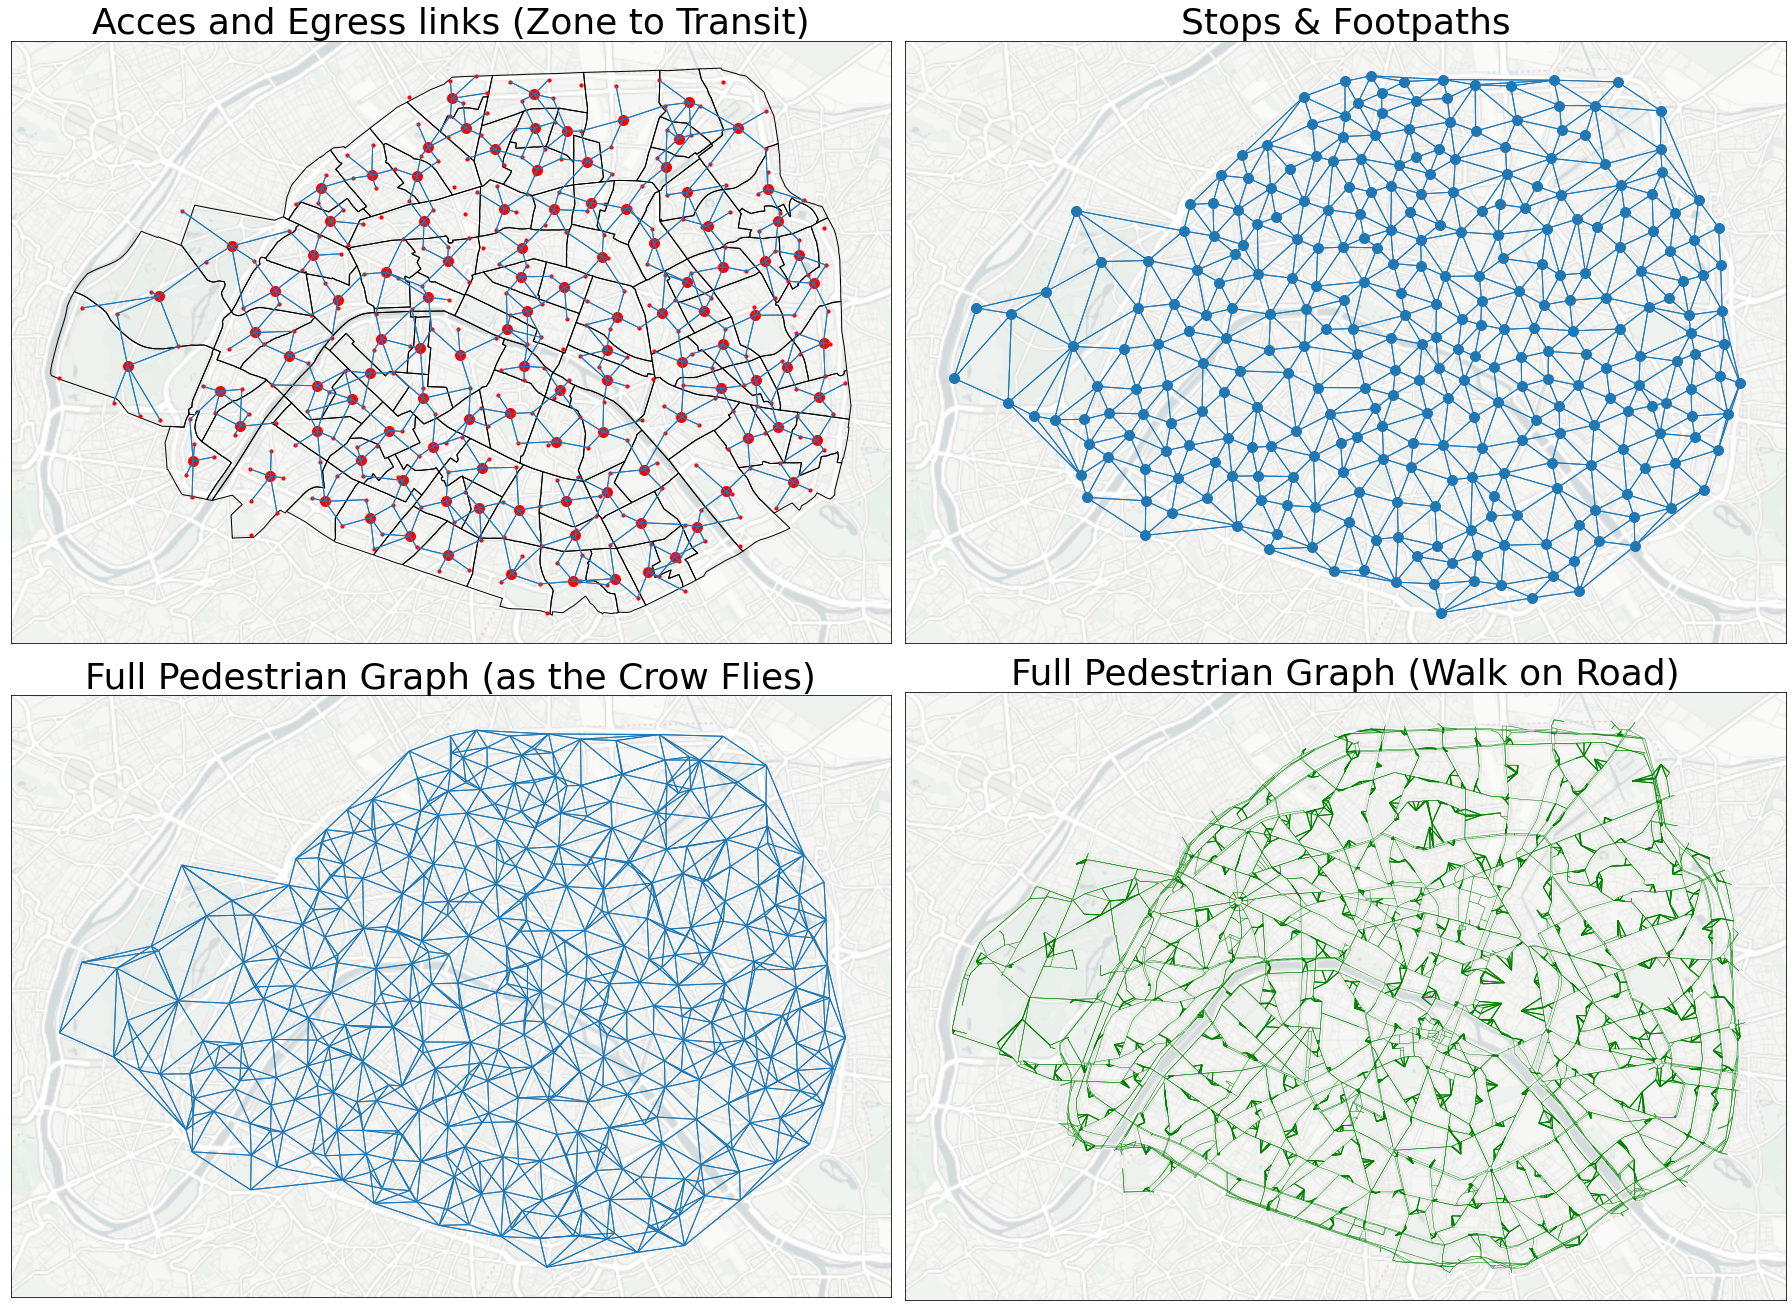

In [ ]:
if manual:
    fig = plot_walkmodel(sm, url = 'http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png')

## zone_to_transit monitoring

Text(0.5, 1.0, 'Access & egress links: speed VS distance')

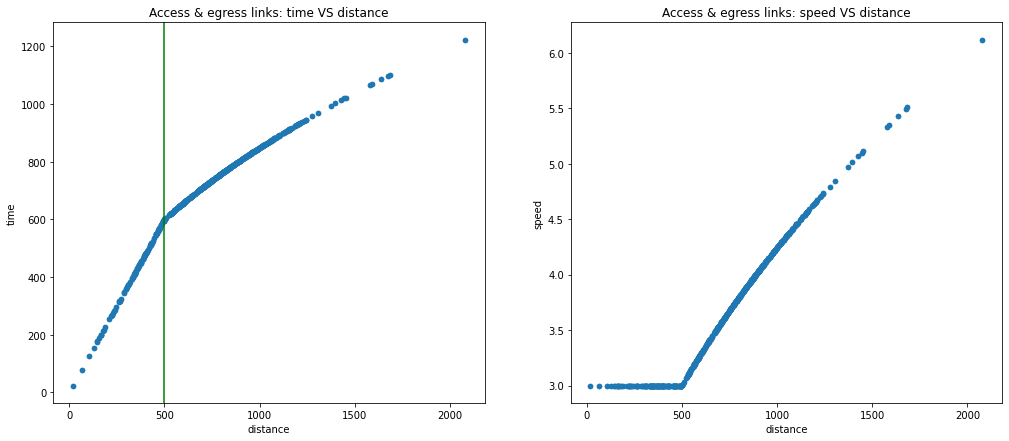

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=[17, 7])
ax = sm.zone_to_transit.plot(kind='scatter', x='distance', y='time', ax=axes[0])
ax.axvline(x=var["preparation_ntlegs"]["threshold"], color='green')
ax.set_title('Access & egress links: time VS distance')
ax = sm.zone_to_transit.plot(kind='scatter', x='distance', y='speed', ax=axes[1])
ax.set_title('Access & egress links: speed VS distance')